In [1]:
import pandas as pd

df = pd.read_csv('stroke.csv')
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
print(len(df))
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())
print(len(df))
df = df[df.smoking_status != 'Unknown']
print(len(df))

5110
5110
3566


In [3]:
print(len(df))

5110


In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
cols = ['gender','ever_married','work_type','Residence_type','smoking_status']
df[cols] = df[cols].apply(le.fit_transform)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.600000,0,1
1,51676,0,61.0,0,0,1,3,0,202.21,28.893237,1,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.500000,1,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.400000,2,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.000000,1,1


In [7]:
class_0 = df.loc[(df['stroke'] == 0)]
class_1 = df.loc[(df['stroke'] == 1)]
print('num of class_0:',len(class_0))
print('num of class_1:',len(class_1))


num of class_0: 3364
num of class_1: 202


#### oversample miniority class

In [11]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

class_1_resampled = resample(class_1, replace = True, n_samples = len(class_0), random_state = 88)

df_resampled = pd.concat([class_0, class_1_resampled])
new_class_0 = df_resampled.loc[(df['stroke'] == 0)]
new_class_1 = df_resampled.loc[(df['stroke'] == 1)]
print('num of class_0:',len(new_class_0))
print('num of class_1:',len(new_class_1))


bx_train, bx_test, by_train, by_test = train_test_split(df_resampled.iloc[:,1:-1],df_resampled['stroke'],test_size = 0.3, random_state = 88)

num of class_0: 3364
num of class_1: 3364


## SVM

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(df[['age', 'avg_glucose_level', 'bmi']])


In [18]:
n_estimators = 10
linearsvm = BaggingClassifier(svm.SVC(kernel='linear'), random_state = 88 ,max_samples=1.0 / n_estimators, n_estimators=n_estimators)
linearsvm.fit(bx_train_scaled, by_train)
y_pred_linearSVM = linearsvm.predict(bx_test_scaled)
print('linearSVM score', linearsvm.score(bx_test_scaled, by_test))

polysvm = BaggingClassifier(svm.SVC(kernel='poly'), random_state = 88,max_samples=1.0 / n_estimators, n_estimators=n_estimators)
polysvm.fit(bx_train_scaled, by_train)
y_pred_polySVM = polysvm.predict(bx_test_scaled)
print('polySVM score', polysvm.score(bx_test_scaled, by_test))

rbfsvm = BaggingClassifier(svm.SVC(kernel='rbf'), random_state = 88,max_samples=1.0 / n_estimators, n_estimators=n_estimators)
rbfsvm.fit(bx_train_scaled, by_train)
y_pred_rbfSVM = rbfsvm.predict(bx_test_scaled)
print('rbfSVM score', rbfsvm.score(bx_test_scaled, by_test))

sigmoidsvm = BaggingClassifier(svm.SVC(kernel='sigmoid'), random_state = 88,max_samples=1.0 / n_estimators, n_estimators=n_estimators)
sigmoidsvm.fit(bx_train_scaled, by_train)
y_pred_sigmoidSVM = sigmoidsvm.predict(bx_test_scaled)
print('sigmoidSVM score', sigmoidsvm.score(bx_test_scaled, by_test))

linearSVM score 0.7424467558197128
polySVM score 0.7558197127290738
rbfSVM score 0.7508667657256067
sigmoidSVM score 0.687964338781575


In [51]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import svm

param_grid = {
    'base_estimator__C': [0.1,1, 10, 100, 1000], 
    'base_estimator__gamma': [1,0.1,0.01,0.001, 0.0001],
}


svm = svm.SVC(kernel = 'poly')

bagging_svm = BaggingClassifier(svm, random_state = 88,max_samples=1.0 / n_estimators, n_estimators=n_estimators)

grid_search = GridSearchCV(
    bagging_svm,
    param_grid=param_grid,
    scoring = 'f1'
)

grid_search.fit(bx_train_scaled, by_train)


print('Best hyper parameters:', grid_search.best_params_, 'Score', grid_search.best_score_)

Best hyper parameters: {'base_estimator__C': 1000, 'base_estimator__gamma': 1} Score 0.8616918555230513


In [52]:
from sklearn import svm

polysvm = BaggingClassifier(svm.SVC(kernel='poly', gamma = 1, C = 1000 ), random_state = 88,max_samples=1.0 / n_estimators, n_estimators=n_estimators, )
polysvm.fit(bx_train_scaled, by_train)
y_pred_SVM = polysvm.predict(bx_test_scaled)
print('polySVM score', polysvm.score(bx_test_scaled, by_test))


polySVM score 0.8717186726102031


In [53]:
from sklearn import metrics

SVM_accuracy = metrics.accuracy_score(by_test, y_pred_SVM)
print("SVM model accuracy:", SVM_accuracy)

SVM_precision = metrics.precision_score(by_test, y_pred_SVM)
print("SVM model precision:", SVM_precision)

SVM_recall = metrics.recall_score(by_test, y_pred_SVM)
print("SVM model recall:", SVM_recall)

SVM_f1_score = metrics.f1_score(by_test, y_pred_SVM)
print("SVM model f1:", SVM_f1_score)

SVM model accuracy: 0.8717186726102031
SVM model precision: 0.810207336523126
SVM model recall: 0.9797492767598843
SVM model f1: 0.8869489305979923


## Logistic Regression

In [30]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:-1],df['stroke'],test_size = 0.3, random_state = 88)

In [47]:
from sklearn.linear_model import LogisticRegression
import numpy as np

weights = np.linspace(0.0,0.99,200)
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

grid_search = GridSearchCV(
    LogisticRegression(random_state = 88),
    param_grid=param_grid,
    scoring = 'f1'
)


grid_search.fit(x_train, y_train)


print('Best hyper parameters:', grid_search.best_params_, 'Score', grid_search.best_score_)


Best hyper parameters: {'class_weight': {0: 0.11442211055276383, 1: 0.8855778894472361}} Score 0.2887040145992918


In [48]:

logreg = LogisticRegression(random_state = 88,  class_weight={0: 0.11442211055276383, 1: 0.8855778894472361})
logreg.fit(x_train, y_train)

y_pred_logreg = logreg.predict(x_test)


In [49]:
LR_accuracy = metrics.accuracy_score(y_test, y_pred_logreg)
print("LR model accuracy:", LR_accuracy)

LR_precision = metrics.precision_score(y_test, y_pred_logreg)
print("LR model precision:", LR_precision)

LR_recall = metrics.recall_score(y_test, y_pred_logreg)
print("LR model recall:", LR_recall)

LR_f1_score = metrics.f1_score(y_test, y_pred_logreg)
print("LR model f1:", LR_f1_score)

LR model accuracy: 0.8383177570093457
LR model precision: 0.18181818181818182
LR model recall: 0.6296296296296297
LR model f1: 0.28215767634854777


[-0.22877774  1.1940948   0.65194558  0.49555629  0.02876236  0.02375774
  0.21599779  0.11090093  0.00372022  0.05996908]
Feature : gender Score: -0.228778
Feature : age Score: 1.194095
Feature : hypertension Score: 0.651946
Feature : heart_disease Score: 0.495556
Feature : ever_married Score: 0.028762
Feature : work_type Score: 0.023758
Feature : Residence_type Score: 0.215998
Feature : avg_glucose_level Score: 0.110901
Feature : bmi Score: 0.003720
Feature : smoking_status Score: 0.059969


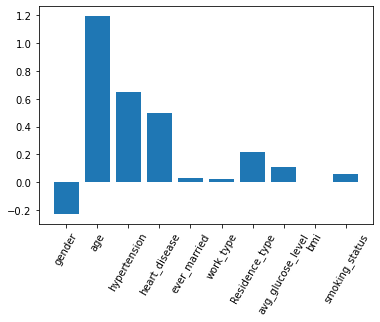

In [87]:
from matplotlib import pyplot

LR_importances = logreg.coef_[0]
print(LR_importances)
for i,v in enumerate(LR_importances):
 print('Feature : %s Score: %f' % (list(df.columns)[1:-1][i], v))
# plot feature importance
pyplot.xticks(rotation = 60) 
pyplot.bar(list(df.columns)[1:-1], LR_importances)
pyplot.show()

#### age is the largest contributor to determining stroke status